In [86]:
import osrs_GE

import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns

from osrs_GE import elliptic_paraboloid_loss as eploss

import matplotlib.pyplot as plt

#### To-do
- Algorithmic way of determining return thresholds for classification?
    - Should be solely based off of some trailing vol ema or updated every x days/intervals

In [88]:
# dragonfire shield
item_id = 11284
freq = '6h'


item_name = osrs_GE.item_name_from_id(item_id)
df = osrs_GE.read_item_master_file(item_id,freq)
df = osrs_GE.compute_VWAP(df)
df['simpRet_y'] = df['VWAP'].shift(-1)/df['VWAP'] - 1
df.head()

File read successfully for Master Files/items/master_file_11284_6h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet_y
date,,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06,-0.006633
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06,-0.047092
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06,0.000898
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06,0.005086
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06,-0.003957


In [144]:
train_dt

Timestamp('2024-09-02 12:00:00')

In [141]:
# create train test split
train_idx = int(.7*df.index.shape[0])
train_dt = df.index[train_idx]

lagged_rets = 5
RSI_window = 8
MACD_short = 2
MACD_long = 8

max_window = int(np.ceil(max(lagged_rets,RSI_window,MACD_long)/(4*(freq=='6h') + 1*(freq=='24h'))))

CTI = osrs_GE.compute_CTI(interval=freq)
CTI_ret = CTI/CTI.shift(1) - 1


DF = osrs_GE.compute_features(df,lagged_rets=lagged_rets,RSI_window=RSI_window,
                             MACD_short=MACD_short,
                             MACD_long=MACD_long)


DF['CTI_ret1'] = CTI_ret
DF = DF.dropna()


# take out 2024-10-01 (servers went down)
# subsequently any features computed that involved that day removed as well
# could be a better way to handle this, but hopefully this minimizes damage from
# the contamination of the bad day

bad_date_fltr = (DF.index > DF.loc['2024-10-01'].index[0] + pd.Timedelta(max_window,'D')) | (DF.index<'2024-10-01')
DF = DF[bad_date_fltr]

df_tr = DF[DF.index < train_dt]
train_length = df_tr.shape[0]

print(df_tr.shape)
#print(df_te.shape)

(328, 19)


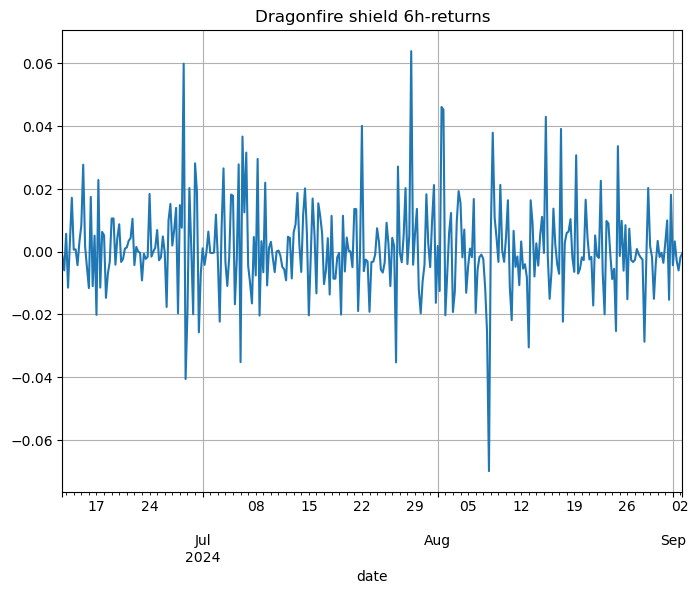

In [142]:
df_tr['simpRet_y'].plot(figsize=(8,6))
plt.title("{0} {1}-returns".format(item_name,freq))
plt.grid()
plt.show()

In [143]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_tr['simpRet_y'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-16.313
p-value:0.0000
lags:1


In [6]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet_y'],seasonal=False,trace=True,max_p=15,max_q=15)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1819.411, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1810.899, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1812.690, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1814.884, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1819.198, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1820.356, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1817.426, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1822.047, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1821.615, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1819.353, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1823.318, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1812.904, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1823.427, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1822.732, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0

In [7]:
auto_res.order

(3, 0, 1)

In [8]:
p,d,q = auto_res.order

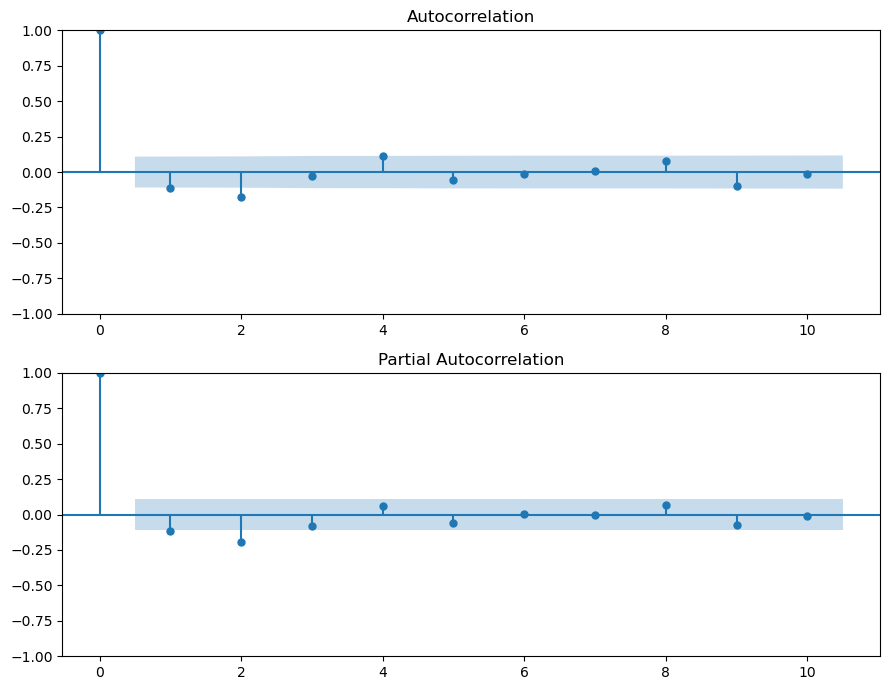

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(df_tr['simpRet_y'],lags=10, ax=ax[0])
plot_pacf(df_tr['simpRet_y'],lags=10, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

What features to include in forecasting price?
- order imbalance (+ lags)
- lagged returns
- TA indicators
  - RSI
  - MACD
  - SMA
  - LMA

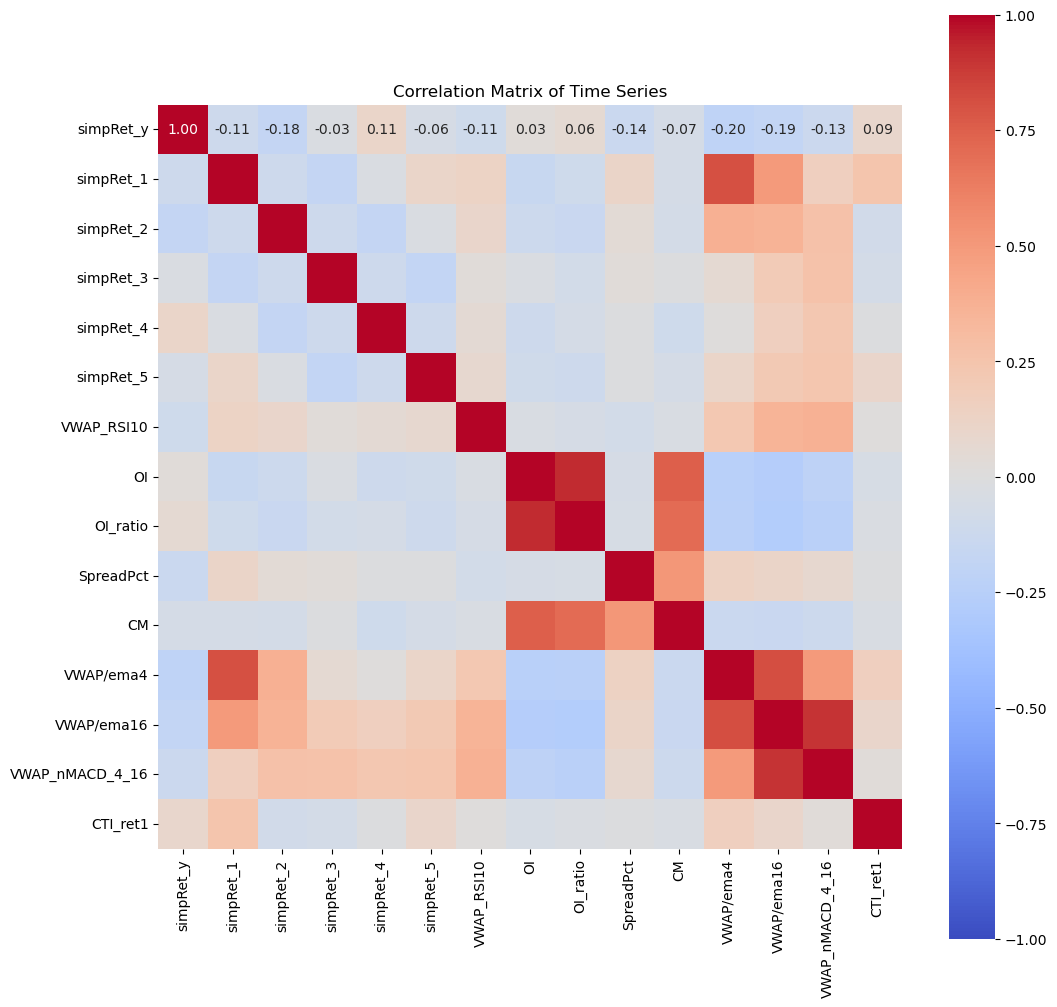

In [10]:
corr_matrix = df_tr.corr()

plt.figure(figsize=(12,12))

sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,vmin=-1,vmax=1)

plt.title('Correlation Matrix of Time Series')
plt.show()

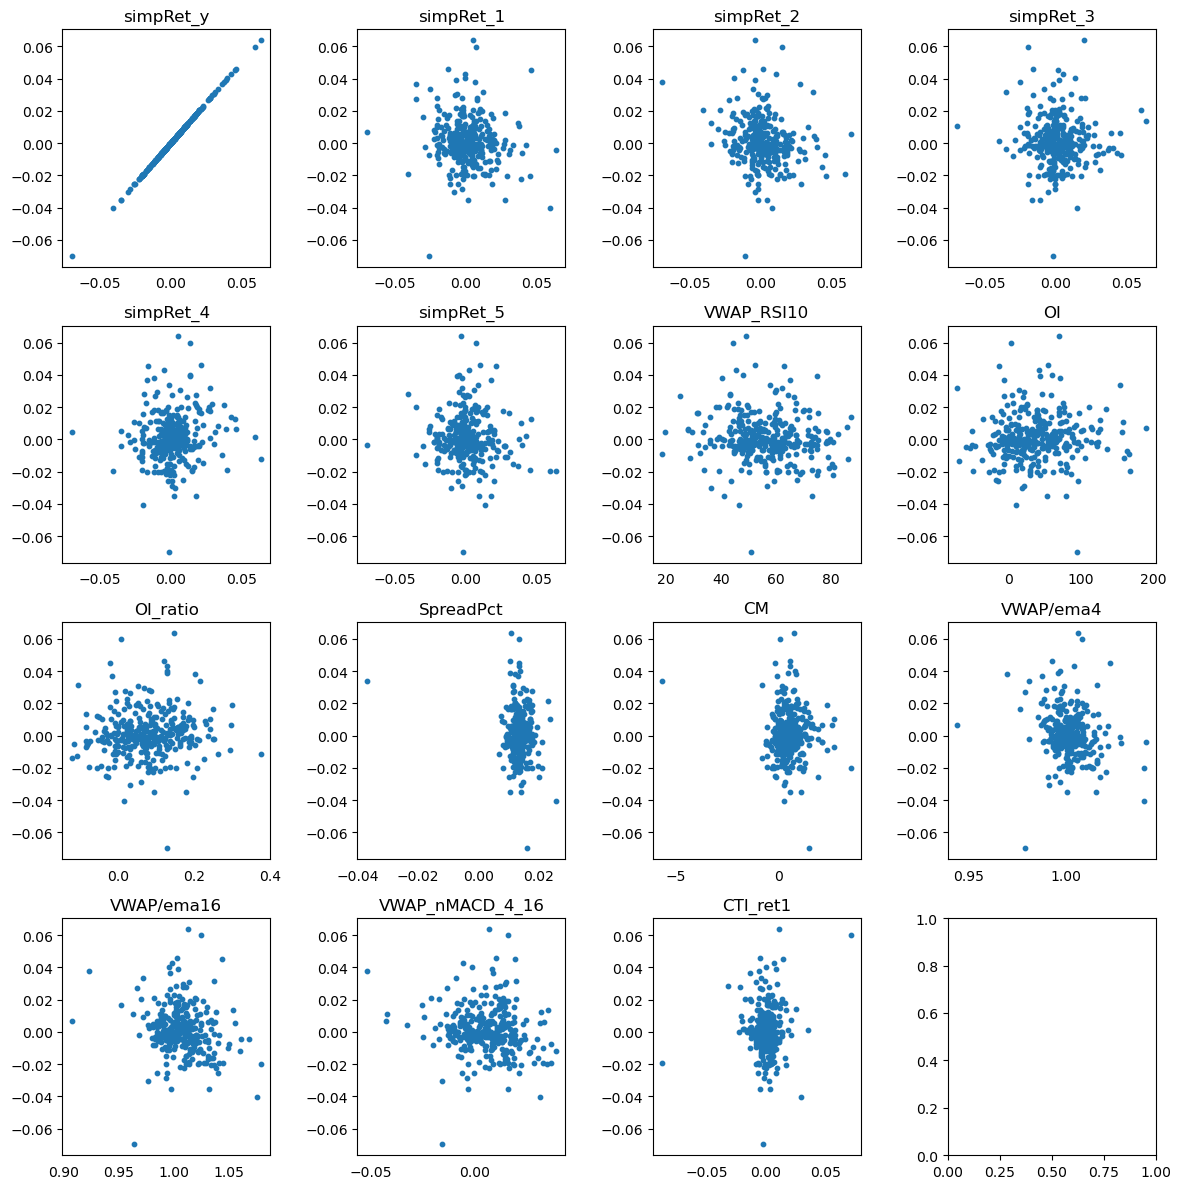

In [11]:
figs,axs = plt.subplots(int(np.ceil(df_tr.shape[1]/4)),4,figsize=(12,12))

ct = 0
for col in df_tr.columns:
    ax = axs[ct//4,ct%4]
    ax.tick_params(bottom=False)
    ax.scatter(df_tr[col],df_tr['simpRet_y'],s=10)
    ax.set_title(col)
    ct += 1
    
figs.tight_layout()
plt.show()

# Return forecasting

## Feature selection for linear models

In [12]:
## Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

X = df_tr.drop('simpRet_y',axis=1).values
y = df_tr['simpRet_y'].values

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
alpha = lasso_cv.best_params_['alpha']
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [13]:
names=df_tr.drop("simpRet_y", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['simpRet_1' 'simpRet_2' 'simpRet_3' 'simpRet_4' 'simpRet_5' 'VWAP_RSI10'
 'OI' 'OI_ratio' 'SpreadPct' 'CM' 'VWAP/ema4' 'VWAP/ema16'
 'VWAP_nMACD_4_16' 'CTI_ret1']


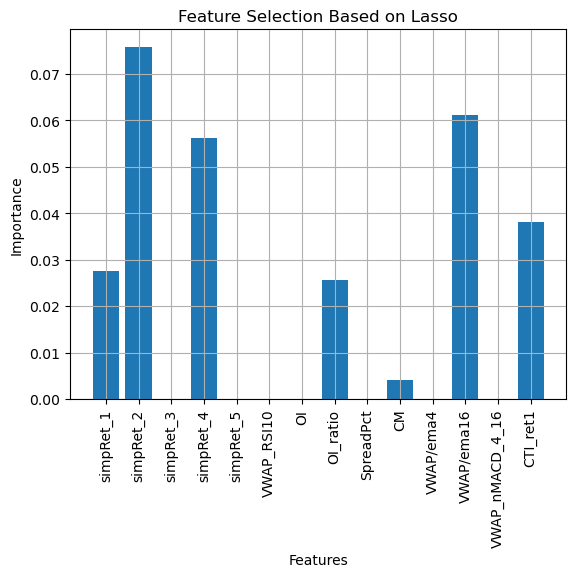

In [14]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [15]:
# Subsetting the features that are relevant.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, 'simpRet_y')
print("Selected Columns: {}".format(feature_subset))

df_tr_new = df_tr[feature_subset]

Selected Feature Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema16'
 'CTI_ret1']
Selected Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema16'
 'CTI_ret1' 'simpRet_y']


In [32]:
def iterative_testing(df,y_col,model=LinearRegression(),start_point=10,plot=True):
    # df is dataframe with all of the predictor variables + response variable
    # specify the name of the response variable column into y_col
    
    X_tr = df.drop(y_col,axis=1).values
    y_tr = df[y_col].values
    feature_shape = X_tr.shape[1]
    start_point = max(feature_shape+5,start_point)
    errors = []
    preds = []
    obs = []
    index = []
    
    for i in range(start_point,X_tr.shape[0]-1):
        # train on data up to i-1
        _X = X_tr[:i]
        _y = y_tr[:i]
        model_fit = model.fit(_X,_y)
        
        # predict i
        x_predict = X_tr[[i]]
        y_hat = model_fit.predict(x_predict)[0]
        y_obs = y_tr[i]
        
        # record errors
        errors.append(y_obs - y_hat)
        preds.append(y_hat)
        obs.append(y_obs)
        
        index.append(df.index[i])
    
    df_err = pd.DataFrame({'errors': errors,
                           'predicted': preds,
                           'observed': obs}, index=index)
    
    if plot:
        df_err[['predicted','observed']].plot(figsize=(6,5))
        plt.ylabel("% return")
        plt.grid()
        plt.title('Predicted vs. Actual returns over time')
        plt.show()
        print('\n')

        df_err.plot(x='predicted', y='observed', style='o',figsize=(6,5))
        plt.grid()
        plt.xlabel('Predicted returns')
        plt.ylabel('Actual returns')
        plt.title('Predicted vs. Actual returns')
        plt.show()
        print('\n')

        df_err.plot(x='observed', y='errors', style='o',figsize=(6,5))
        plt.grid()
        plt.xlabel('Actual returns')
        plt.ylabel('Prediction error')
        plt.title('Error vs. Actual returns')
        plt.show()
    
    reg_eploss = eploss(df_err['predicted'],df_err['observed']).mean()
    reg_mse = (df_err['errors']**2).mean()
    print("Mean EPLoss: ", reg_eploss)
    print("MSE: ", reg_mse)
    return df_err

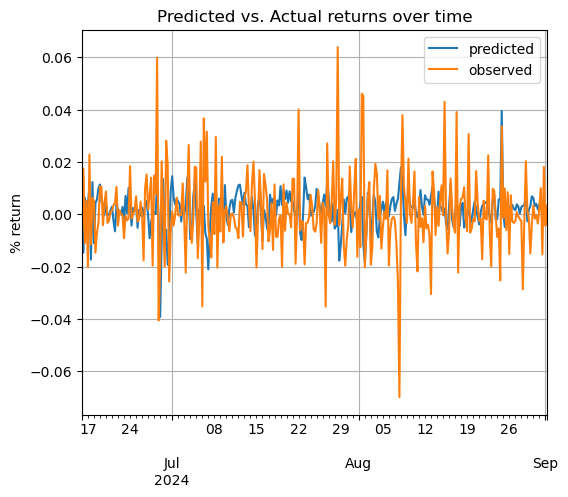

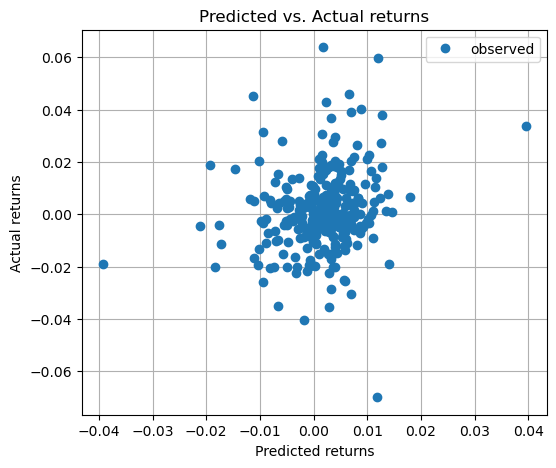

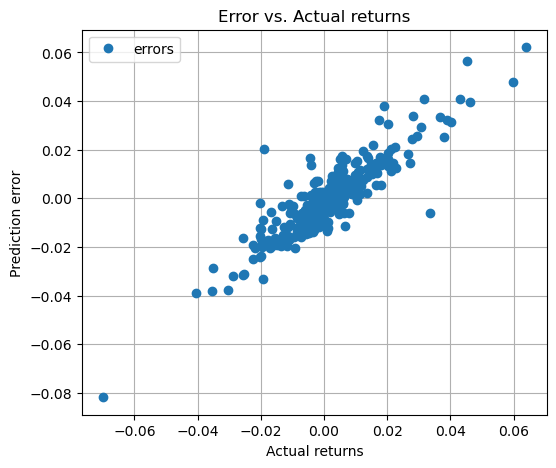

Mean EPLoss:  0.0011761295169909357
MSE:  0.00022752761307182198


In [33]:
model = LinearRegression()
#linear_reg_res = osrs_GE.iterative_testing(df_tr_new,'simpRet_y',model=model)
lr_train_res = iterative_testing(df_tr_new,'simpRet_y',model=model)

#### Benchmarking with an ARIMA model

In [34]:
start_point = 10

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

arima_result = osrs_GE.ARIMA_CV_SCORE(df_tr_new['simpRet_y'],order=(p,d,q),start_point=start_point,
                                     custom_scorer=eploss)

In [35]:
print("ARIMA mean EPloss: ",arima_result['custom_scores'].mean())
print("ARIMA MSE: ",(arima_result['errors']**2).mean())

ARIMA mean EPloss:  0.0012380038237443476
ARIMA MSE:  0.00024091059152453782


## Reframing the problem as classification for an investing strategy

In [36]:
trading_results = {}

In [37]:
# defining the % return threshold for trading strategy
# buy when pred > .005, sell when pred < -.0075

q_b , q_s = .005,-.0075

(1.0*(df_tr['simpRet_y'] > q_b) - (df_tr['simpRet_y'] < q_s)).value_counts()

simpRet_y
 0.0    156
 1.0    103
-1.0     64
Name: count, dtype: int64

### revisiting linear regression as a classifier

In [38]:
lr_train_res['signal'] = 1.0*(lr_train_res['predicted']>q_b) - (lr_train_res['predicted'] < q_s)

lr_train_res = lr_train_res.join(df['VWAP'])
lr_train_res = lr_train_res.rename({'VWAP':'VWAP_trade'},axis=1)

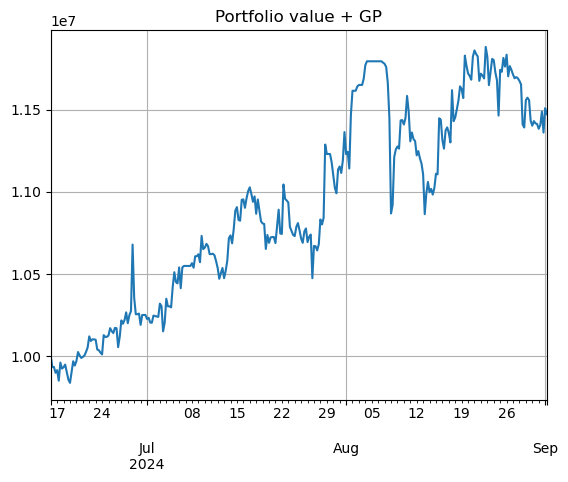

                     inventory         stack  total_portfolio
2024-09-01 06:00:00        2.0  3.153944e+06     1.147264e+07


In [39]:
trading_results['lin_reg'] = osrs_GE.trading_strategy_pnler(lr_train_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg'].tail(1))

### revisiting ARIMA

In [40]:
arima_result['ret_df']['signal'] = 1.0*(arima_result['ret_df']['Pred'] > q_b) - 1.0*(arima_result['ret_df']['Pred'] < q_s)

In [41]:
arima_result['ret_df'] = arima_result['ret_df'].join(df['VWAP'])
arima_result['ret_df'].rename({'VWAP':'VWAP_trade'},axis=1,inplace=True)

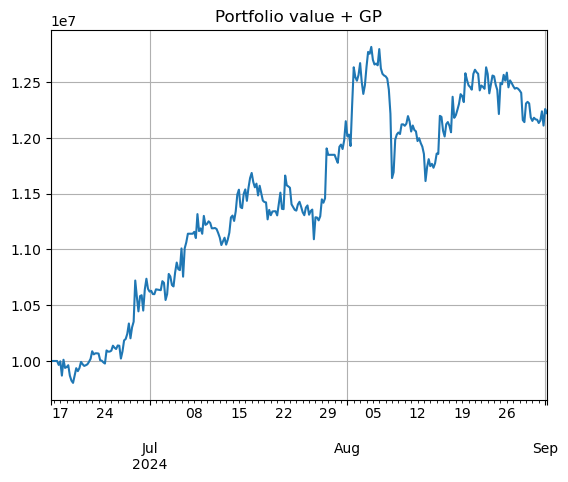

inventory          2.000000e+00
stack              3.904418e+06
total_portfolio    1.222311e+07
Name: 2024-09-01 06:00:00, dtype: float64


In [42]:
trading_results['arima_train'] = osrs_GE.trading_strategy_pnler(arima_result['ret_df'],
                                                                max_allowable=2,
                                                                start_stack = 10e6)
print(trading_results['arima_train'].iloc[-1])

#### On the test set

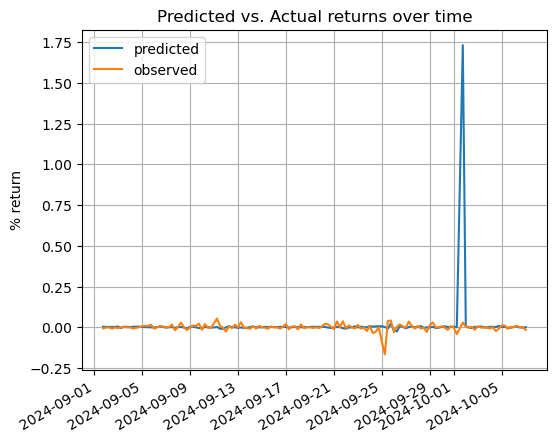

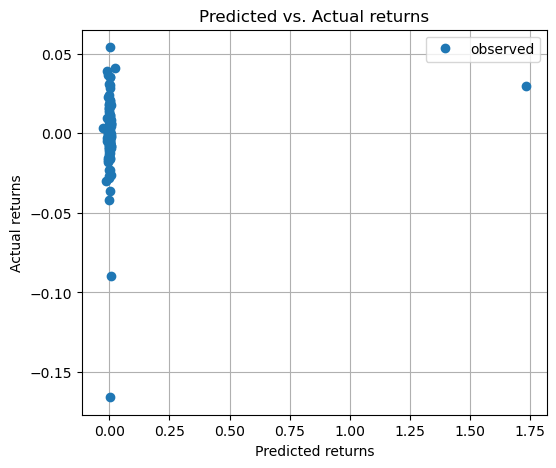

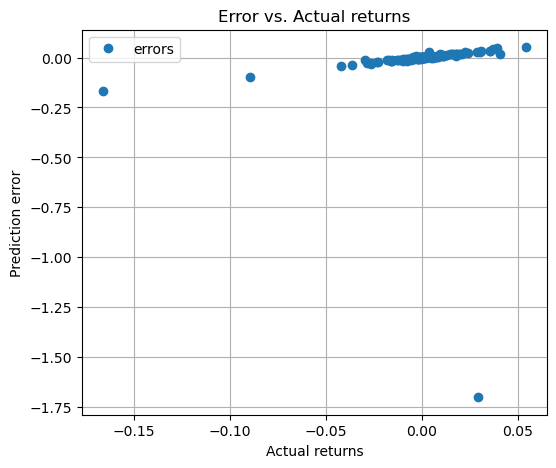

Mean EPLoss:  0.107844653337606
MSE:  0.021007323884981208


In [43]:
df_copy = df.copy()
df_copy = osrs_GE.compute_features(df_copy,lagged_rets=lagged_rets,RSI_window=RSI_window,
                                 MACD_short = MACD_short,
                                 MACD_long = MACD_long)


df_copy = df_copy.dropna().join(CTI_ret).rename({'CTI_px':'CTI_ret1'},axis=1)[feature_subset]
lr_test_res = iterative_testing(df_copy,'simpRet_y',model=LinearRegression(),start_point = train_length)

lr_test_res['signal'] = 1.0*(lr_test_res['predicted']>q_b) - (lr_test_res['predicted'] < q_s)
lr_test_res = lr_test_res.join(df['VWAP'])

lr_test_res = lr_test_res.rename({'VWAP':'VWAP_trade'},axis=1)

In [44]:
lr_test_res['signal'].value_counts()

signal
 0.0    119
 1.0     16
-1.0      6
Name: count, dtype: int64

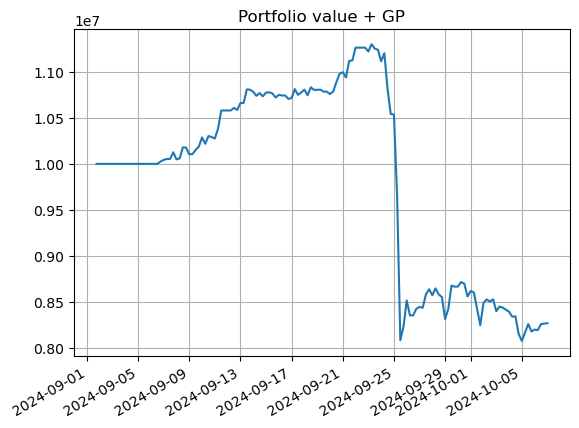

inventory          2.000000e+00
stack              1.030848e+05
total_portfolio    8.268938e+06
Name: 2024-10-07 00:00:00, dtype: float64


In [45]:
trading_results['lin_reg_test'] = osrs_GE.trading_strategy_pnler(lr_test_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg_test'].iloc[-1])

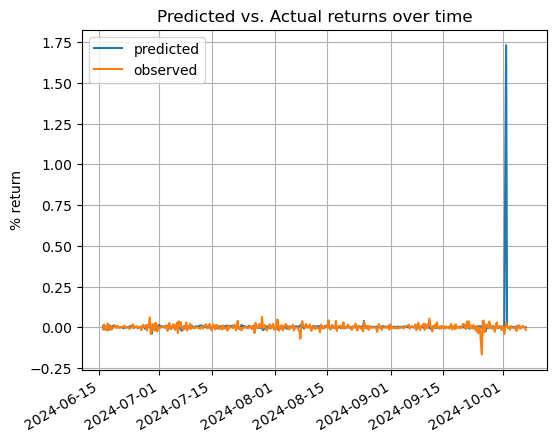

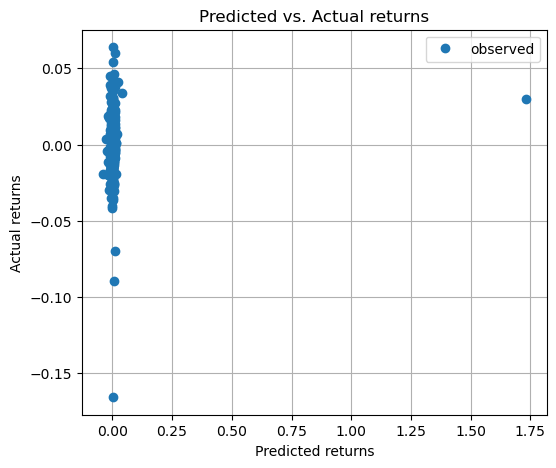

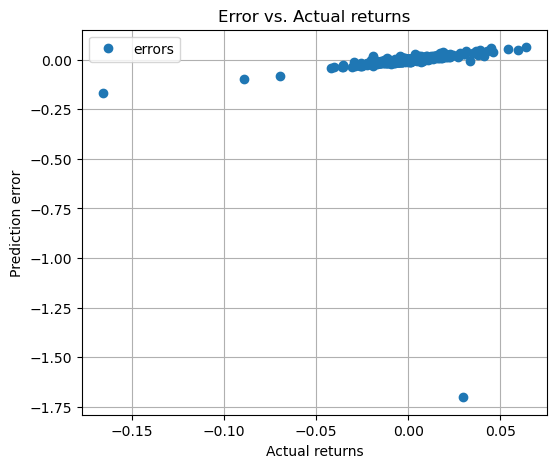

Mean EPLoss:  0.034448532983758995
MSE:  0.006709234831536893


In [46]:
lr = iterative_testing(df_copy,'simpRet_y',model=LinearRegression(),start_point = 10)

In [47]:
df_copy = df.copy()
df_copy = df_copy.dropna()

In [48]:
arima_test = osrs_GE.ARIMA_CV_SCORE(df_copy['simpRet_y'],order=(p,d,q),start_point = train_length,custom_scorer=eploss)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a 

In [49]:
print("ARIMA order: ({0},{1},{2})".format(p,d,q))
print("ARIMA mean EPloss: ",arima_test['custom_scores'].mean())
print("ARIMA MSE: ",(arima_test['errors']**2).mean())

ARIMA order: (3,0,1)
ARIMA mean EPloss:  0.0027228910869528927
ARIMA MSE:  0.0005334814468713003


In [50]:
arima_test_res = arima_test['ret_df']

arima_test_res['signal'] = 1.0*(arima_test_res['Pred']>q_b) - (arima_test_res['Pred'] < q_s)
arima_test_res = arima_test_res.join(df['VWAP'])
arima_test_res = arima_test_res.rename({'VWAP':'VWAP_trade'},axis=1)

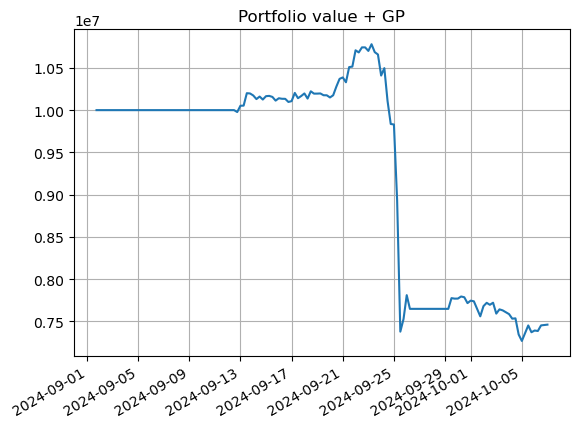

inventory          2.000000e+00
stack             -7.041656e+05
total_portfolio    7.461688e+06
Name: 2024-10-07 00:00:00, dtype: float64


In [51]:
trading_results['arima_test_({0},{1},{2})'.format(p,d,q)] = osrs_GE.trading_strategy_pnler(arima_test_res,max_allowable=2,start_stack = 10e6)
print(trading_results['arima_test_({0},{1},{2})'.format(p,d,q)].iloc[-1])

### Other methods for classification

In [52]:
print(q_b, q_s)
df_tr['signal_y'] = 1*(df_tr['simpRet_y']>q_b) - (df_tr['simpRet_y']<q_s)

0.005 -0.0075


/var/folders/hq/g_wf2hyx7wv0cnr8_ttnkklw0000gn/T/ipykernel_75809/3060884255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['signal_y'] = 1*(df_tr['simpRet_y']>q_b) - (df_tr['simpRet_y']<q_s)


In [53]:
df_tr2 = df_tr.copy().drop('simpRet_y',axis=1)

In [54]:
def _scorer(y_true,y_pred,neut = 1,opp=3):
    diff = np.abs(y_true - y_pred)
    res = 0*(diff == 0) - neut*(diff == 1) - opp*(diff > 1)
    return res.mean()
    
from sklearn.metrics import make_scorer

scorer = make_scorer(_scorer)

In [64]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators':[50,80,100,150,200,250,300],
    'max_depth':[3,4,5,6,7]
}

X = df_tr2.drop('signal_y',axis=1).values
y = df_tr2['signal_y'].values


rfc_cv = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,scoring=scorer)
rfc_cv.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 80, 100, 150, 200, 250, 300]},
             scoring=make_scorer(_scorer))

In [65]:
rfc_cv.best_params_

{'max_depth': 3, 'n_estimators': 100}

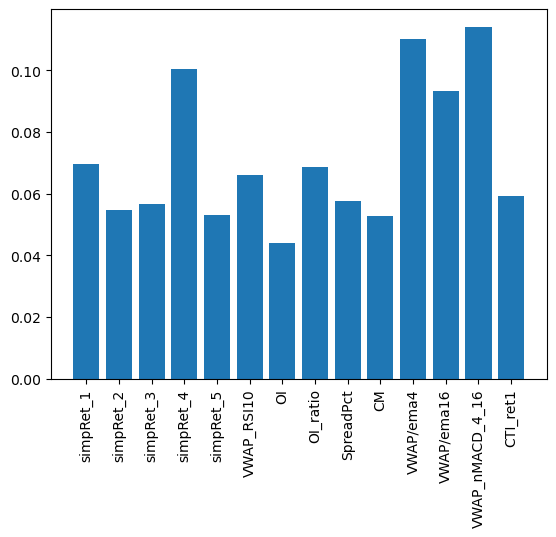

[[ 28  34   2]
 [  0 155   1]
 [  1  42  60]]


In [57]:
rfc_train = RandomForestClassifier(n_estimators = rfc_cv.best_params_['n_estimators'],
                                   max_depth = rfc_cv.best_params_['max_depth'],
                                   random_state = 8)
rfc_train.fit(X,y)

yhat = rfc_train.predict(X)

plt.bar(x = df_tr2.drop('signal_y',axis=1).columns,height = rfc_train.feature_importances_)
plt.xticks(rotation=90)
plt.show()

from sklearn.metrics import confusion_matrix
conf_matr = confusion_matrix(y,yhat,labels=[-1,0,1])
print(conf_matr)

rfc_signal_df = pd.DataFrame({'signal':yhat},index=df_tr2.index).join(df['VWAP']).rename({'VWAP':'VWAP_trade'},axis=1)

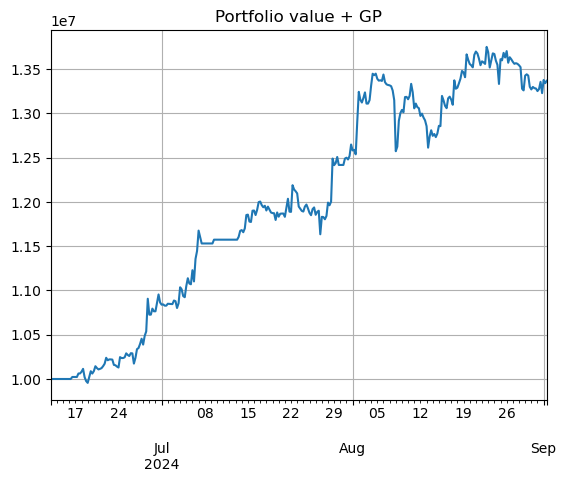

In [58]:
trading_results['rfc_train'] = osrs_GE.trading_strategy_pnler(rfc_signal_df,max_allowable=2,start_stack = 10e6)

In [59]:
df_te = DF.copy()
df_te['signal_y'] = 1*(df_te['simpRet_y']> q_b) - 1*(df_te['simpRet_y'] < q_s)
df_te[df_tr2.columns]

rfc_te_preds = iterative_testing(df_te[df_tr2.columns],y_col='signal_y',model=rfc_train,
                                 start_point = df_tr2.shape[0],plot=False)

Mean EPLoss:  4.008865248226949
MSE:  0.7801418439716312
